In [1]:
import os
import random
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Running on CPU.")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

EMBEDDING_MARGIN = "0.4"
BAGS_DIR = Path("/workspace/MIL/data/processed/bags")
BAG_VERSION = "baseline"
MIX_RATIO_TARGET = 0.30
BAG_SIZE_GRID = [10, 20, 30, 40, 50]

BATCH_SIZE = 16
MAX_EPOCHS = 10
PATIENCE = 3
LEARNING_RATE = 1e-3

print(f"Stage 2 bag directory: {BAGS_DIR}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
Stage 2 bag directory: /workspace/MIL/data/processed/bags


In [2]:
def format_ratio_tag(instances):
    return f"{int(round(MIX_RATIO_TARGET * 100)):02d}p_single{instances:02d}"


def load_stage2_split(ratio_tag, split, version=BAG_VERSION):
    filename = f"bags_arcface_margin_{EMBEDDING_MARGIN}_{ratio_tag}_{version}_{split}.pkl"
    path = BAGS_DIR / filename
    if not path.exists():
        raise FileNotFoundError(f"Missing Stage 2 output: {path}")
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data


def flatten_bags(bags):
    flattened = []
    for bag in bags:
        bag = bag.astype(np.float32)
        flattened.append(bag.reshape(bag.shape[0], -1))
    return flattened


def prepare_data_for_ratio(ratio_tag):
    splits = {}
    instance_dim = None
    instances_per_bag = None
    for split in ("train", "val", "test"):
        payload = load_stage2_split(ratio_tag, split)
        bags = payload["bags"]
        features = flatten_bags(bags)
        labels = [int(y) for y in payload["labels"]]
        meta = payload.get("metadata", [])
        splits[split] = {"features": features, "labels": labels, "meta": meta}
        if instance_dim is None and features:
            instance_dim = features[0].shape[1]
            instances_per_bag = bags[0].shape[0]
    if instance_dim is None:
        raise RuntimeError(f"No bags found for ratio_tag={ratio_tag}")
    print(f"[{ratio_tag}] Instances per bag: {instances_per_bag}, feature dim: {instance_dim}")
    return splits, instances_per_bag, instance_dim


def summarize_partner_mix(meta_list, labels, split_name, expected_ratio, instances_per_bag):
    pos_meta = [m for m, y in zip(meta_list, labels) if y == 1]
    if not pos_meta:
        print(f"  {split_name} set has no positive bags.")
        return
    counts = []
    ratios = []
    for meta in pos_meta:
        count = meta.get("partner_instance_count")
        ratio = meta.get("partner_instance_ratio")
        if count is None or ratio is None:
            instances = meta.get("instances", [])
            anchor = meta.get("anchor_writer_id")
            computed = 0
            for inst in instances:
                src = inst.get("source_writer")
                if src is None:
                    writer_ids = inst.get("writer_ids", [])
                    src = writer_ids[0] if writer_ids else None
                if anchor is None:
                    writer_ids = inst.get("writer_ids", [])
                    anchor = writer_ids[0] if writer_ids else None
                if src is not None and anchor is not None and src != anchor:
                    computed += 1
            count = computed
            ratio = computed / len(instances) if instances else 0.0
        counts.append(count)
        ratios.append(ratio)
    counts_arr = np.array(counts)
    ratios_arr = np.array(ratios)
    expected_count = int(round(instances_per_bag * expected_ratio))
    print(f"  {split_name} partner count stats: min={counts_arr.min()}, max={counts_arr.max()}, mean={counts_arr.mean():.2f}")
    print(f"  {split_name} partner ratio stats: min={ratios_arr.min():.2f}, max={ratios_arr.max():.2f}, mean={ratios_arr.mean():.2f}")
    all_match = np.all(counts_arr == expected_count)
    print(f"  {split_name} counts match expected {expected_count}? {'Yes' if all_match else 'No'}")


def compute_pos_weight(labels):
    positives = sum(labels)
    negatives = len(labels) - positives
    if positives == 0:
        return 1.0
    return negatives / positives

In [3]:
class MILDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y


def make_dataloaders(splits, batch_size=BATCH_SIZE):
    loaders = {}
    for split, data in splits.items():
        shuffle = split == "train"
        dataset = MILDataset(data["features"], data["labels"])
        loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loaders

In [4]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        # bag_mean(H) + bag_std(H) + 4 scalars = 2H + 4
        self.classifier = nn.Linear(hidden_dim * 2 + 4, 1)
        self._init_weights()

    def _init_weights(self):
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity="relu")
        nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.att_fc1.weight); nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight); nn.init.zeros_(self.att_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight); nn.init.zeros_(self.classifier.bias)

    def forward(self, x):
        # 1) ArcFace 일관성: 입력 L2 정규화
        x = F.normalize(x, p=2, dim=-1)

        # 2) 인스턴스 임베딩
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)

        # 3) 어텐션 가중치 (softmax)
        att = torch.tanh(self.att_fc1(h))
        att_logits = self.att_fc2(att).squeeze(-1)          # (B, N)
        weights = torch.softmax(att_logits, dim=1)          # (B, N)

        # 4) bag 표현 + 통계
        bag_mean = h.mean(dim=1)                            # (B, H)
        bag_std  = h.std(dim=1)                             # (B, H)

        # (a) 인스턴스–평균 거리 통계
        h_mean = h.mean(dim=1, keepdim=True)                # (B, 1, H)
        dist_to_mean = torch.norm(h - h_mean, p=2, dim=-1)  # (B, N)
        dist_max = dist_to_mean.max(dim=1).values           # (B,)
        dist_weighted = (weights * dist_to_mean).sum(dim=1) # (B,)

        # (b) 인스턴스 간 pairwise 거리 통계 (대각 제외, 상삼각)
        pairwise = torch.cdist(h, h, p=2)                   # (B, N, N)
        n_inst = pairwise.size(1)
        mask = torch.triu(torch.ones(n_inst, n_inst, dtype=torch.bool, device=h.device), diagonal=1)
        pairwise_upper = pairwise[:, mask]                  # (B, N*(N-1)/2)
        pairwise_max = pairwise_upper.max(dim=1).values     # (B,)
        pairwise_mean = pairwise_upper.mean(dim=1)          # (B,)

        # (c) 4개 스칼라 묶음 + 최종 입력
        scalar_feats = torch.stack([dist_max, dist_weighted, pairwise_max, pairwise_mean], dim=1)  # (B, 4)
        bag_feat = torch.cat([bag_mean, bag_std, scalar_feats], dim=1)  # (B, 2H+4)
        bag_feat = self.dropout(bag_feat)

        logits = self.classifier(bag_feat).squeeze(-1)      # (B,)
        return logits, weights

In [5]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    preds_all = []
    labels_all = []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        preds_all.extend(preds.detach().cpu().numpy())
        labels_all.extend(y.detach().cpu().numpy())
    acc = accuracy_score(labels_all, preds_all) if preds_all else 0.0
    mean_loss = total_loss / len(loader.dataset) if len(loader.dataset) else 0.0
    return mean_loss, acc


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    probs_all = []
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            probs_all.extend(probs.detach().cpu().numpy())
            preds_all.extend(preds.detach().cpu().numpy())
            labels_all.extend(y.detach().cpu().numpy())
    labels_arr = np.array(labels_all)
    probs_arr = np.array(probs_all)
    preds_arr = np.array(preds_all)
    acc = accuracy_score(labels_arr, preds_arr) if labels_arr.size else 0.0
    auc = roc_auc_score(labels_arr, probs_arr) if np.unique(labels_arr).size > 1 else 0.0
    f1 = f1_score(labels_arr, preds_arr) if np.unique(preds_arr).size > 1 else 0.0
    mean_loss = total_loss / len(loader.dataset) if len(loader.dataset) else 0.0
    return mean_loss, acc, auc, f1, probs_arr, labels_arr, preds_arr


def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, max_epochs=MAX_EPOCHS, patience=PATIENCE, name="attention_mil"):
    best_auc = 0.0
    best_state = None
    epochs_no_improve = 0
    epochs_run = 0
    for epoch in range(1, max_epochs + 1):
        epochs_run = epoch
        print(f"\nEpoch {epoch}/{max_epochs} – {name}")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, val_auc, val_f1, _, _, _ = evaluate(model, val_loader, criterion)
        print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}, F1: {val_f1:.4f}")
        scheduler.step(val_auc)
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
            print(f"  ✅ New best AUC: {best_auc:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  No improvement. Patience: {epochs_no_improve}/{patience}")
            if epochs_no_improve >= patience:
                print("  🛑 Early stopping triggered.")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_auc, epochs_run


def find_best_threshold(probs, labels, candidate_thresholds=None):
    if candidate_thresholds is None:
        candidate_thresholds = np.linspace(0.05, 0.95, 19)
    best_thr = 0.5
    best_f1 = 0.0
    labels = np.asarray(labels)
    for thr in candidate_thresholds:
        preds = (probs >= thr).astype(int)
        if np.unique(preds).size < 2:
            continue
        score = f1_score(labels, preds)
        if score > best_f1:
            best_f1 = score
            best_thr = float(thr)
    preds_default = (probs >= 0.5).astype(int)
    if np.unique(preds_default).size >= 2:
        score_default = f1_score(labels, preds_default)
        if score_default > best_f1:
            best_f1 = score_default
            best_thr = 0.5
    return best_thr, best_f1

In [6]:
def run_attention_mil_experiment(bag_size, ratio_tag, splits, instance_dim):
    loaders = make_dataloaders(splits, batch_size=BATCH_SIZE)
    train_labels = splits["train"]["labels"]
    pos_weight_value = compute_pos_weight(train_labels)
    print(f"  Class balance: neg={len(train_labels) - sum(train_labels)}, pos={sum(train_labels)} → pos_weight={pos_weight_value:.2f}")
    pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    model = AttentionMIL(input_dim=instance_dim, hidden_dim=128, dropout_p=0.1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=1, verbose=True)

    model, best_auc, epochs_run = train_model(
        model,
        loaders["train"],
        loaders["val"],
        optimizer,
        scheduler,
        criterion,
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        name=f"attention_mil_{ratio_tag}"
    )

    val_metrics = evaluate(model, loaders["val"], criterion)
    val_loss, val_acc, val_auc, val_f1, val_probs, val_labels_np, _ = val_metrics
    best_thr, best_val_f1 = find_best_threshold(val_probs, val_labels_np)

    test_metrics = evaluate(model, loaders["test"], criterion)
    test_loss, test_acc, test_auc, test_f1_default, test_probs, test_labels_np, _ = test_metrics
    test_preds_best = (test_probs >= best_thr).astype(int)
    test_acc_best = accuracy_score(test_labels_np, test_preds_best)
    test_f1_best = f1_score(test_labels_np, test_preds_best) if np.unique(test_preds_best).size > 1 else test_f1_default
    test_precision_best = precision_score(test_labels_np, test_preds_best, zero_division=0)
    test_recall_best = recall_score(test_labels_np, test_preds_best, zero_division=0)

    record = {
        "bag_size": bag_size,
        "ratio_tag": ratio_tag,
        "pos_weight": round(pos_weight_value, 4),
        "epochs_run": epochs_run,
        "best_val_auc": round(best_auc, 4),
        "val_loss": round(val_loss, 4),
        "val_acc": round(val_acc, 4),
        "val_f1@0.5": round(val_f1, 4),
        "val_f1@best": round(best_val_f1, 4),
        "best_threshold": round(best_thr, 4),
        "test_loss": round(test_loss, 4),
        "test_acc@0.5": round(test_acc, 4),
        "test_f1@0.5": round(test_f1_default, 4),
        "test_auc": round(test_auc, 4),
        "test_acc@best": round(test_acc_best, 4),
        "test_f1@best": round(test_f1_best, 4),
        "test_precision@best": round(test_precision_best, 4),
        "test_recall@best": round(test_recall_best, 4),
    }
    return record


In [7]:
experiment_records = []
for bag_size in BAG_SIZE_GRID:
    ratio_tag = format_ratio_tag(bag_size)
    print(f"\n===== Bag size {bag_size} (ratio_tag={ratio_tag}) =====")
    splits, instances_per_bag, instance_dim = prepare_data_for_ratio(ratio_tag)
    summarize_partner_mix(splits["train"]["meta"], splits["train"]["labels"], "Train", MIX_RATIO_TARGET, instances_per_bag)
    summarize_partner_mix(splits["val"]["meta"], splits["val"]["labels"], "Val", MIX_RATIO_TARGET, instances_per_bag)
    record = run_attention_mil_experiment(bag_size, ratio_tag, splits, instance_dim)
    experiment_records.append(record)

results_df = pd.DataFrame(experiment_records)
results_df


===== Bag size 10 (ratio_tag=30p_single10) =====
[30p_single10] Instances per bag: 10, feature dim: 256
  Train partner count stats: min=3, max=3, mean=3.00
  Train partner ratio stats: min=0.30, max=0.30, mean=0.30
  Train counts match expected 3? Yes
  Val partner count stats: min=3, max=3, mean=3.00
  Val partner ratio stats: min=0.30, max=0.30, mean=0.30
  Val counts match expected 3? Yes
  Class balance: neg=2520, pos=1080 → pos_weight=2.33


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10 – attention_mil_30p_single10
  Train Loss: 0.9405, Acc: 0.4889
  Val   Loss: 0.9135, Acc: 0.7833, AUC: 0.8274, F1: 0.6438
  ✅ New best AUC: 0.8274

Epoch 2/10 – attention_mil_30p_single10
  Train Loss: 0.8305, Acc: 0.7106
  Val   Loss: 0.8660, Acc: 0.7708, AUC: 0.8285, F1: 0.4330
  ✅ New best AUC: 0.8285

Epoch 3/10 – attention_mil_30p_single10
  Train Loss: 0.7381, Acc: 0.7772
  Val   Loss: 0.8372, Acc: 0.7883, AUC: 0.8289, F1: 0.5153
  ✅ New best AUC: 0.8289

Epoch 4/10 – attention_mil_30p_single10
  Train Loss: 0.6674, Acc: 0.8008
  Val   Loss: 0.7920, Acc: 0.8158, AUC: 0.8544, F1: 0.5900
  ✅ New best AUC: 0.8544

Epoch 5/10 – attention_mil_30p_single10
  Train Loss: 0.6312, Acc: 0.8119
  Val   Loss: 0.8566, Acc: 0.7950, AUC: 0.8475, F1: 0.5176
  No improvement. Patience: 1/3

Epoch 6/10 – attention_mil_30p_single10
  Train Loss: 0.5911, Acc: 0.8372
  Val   Loss: 0.8827, Acc: 0.7983, AUC: 0.8419, F1: 0.5310
  No improvement. Patience: 2/3

Epoch 7/10 – attention_mil_30p_

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9469, Acc: 0.4814
  Val   Loss: 0.9231, Acc: 0.8017, AUC: 0.8365, F1: 0.5810
  ✅ New best AUC: 0.8365

Epoch 2/10 – attention_mil_30p_single20
  Train Loss: 0.8499, Acc: 0.6942
  Val   Loss: 0.8325, Acc: 0.8158, AUC: 0.8435, F1: 0.6687
  ✅ New best AUC: 0.8435

Epoch 3/10 – attention_mil_30p_single20
  Train Loss: 0.7403, Acc: 0.7819
  Val   Loss: 0.7789, Acc: 0.8200, AUC: 0.8671, F1: 0.6224
  ✅ New best AUC: 0.8671

Epoch 4/10 – attention_mil_30p_single20
  Train Loss: 0.6761, Acc: 0.7994
  Val   Loss: 0.8851, Acc: 0.7733, AUC: 0.8533, F1: 0.4237
  No improvement. Patience: 1/3

Epoch 5/10 – attention_mil_30p_single20
  Train Loss: 0.6187, Acc: 0.8192
  Val   Loss: 0.8737, Acc: 0.7883, AUC: 0.8682, F1: 0.4816
  ✅ New best AUC: 0.8682

Epoch 6/10 – attention_mil_30p_single20
  Train Loss: 0.5794, Acc: 0.8297
  Val   Loss: 0.9235, Acc: 0.7842, AUC: 0.8501, F1: 0.4830
  No improvement. Patience: 1/3

Epoch 7/10 – attention_mil_30p_single20
  Train Loss: 0.5534, Acc: 0.844

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9532, Acc: 0.4717
  Val   Loss: 0.9313, Acc: 0.7625, AUC: 0.8044, F1: 0.5226
  ✅ New best AUC: 0.8044

Epoch 2/10 – attention_mil_30p_single30
  Train Loss: 0.8669, Acc: 0.6864
  Val   Loss: 0.8554, Acc: 0.8008, AUC: 0.8334, F1: 0.5956
  ✅ New best AUC: 0.8334

Epoch 3/10 – attention_mil_30p_single30
  Train Loss: 0.7540, Acc: 0.7692
  Val   Loss: 0.8239, Acc: 0.7900, AUC: 0.8679, F1: 0.4919
  ✅ New best AUC: 0.8679

Epoch 4/10 – attention_mil_30p_single30
  Train Loss: 0.6722, Acc: 0.8128
  Val   Loss: 0.8395, Acc: 0.7925, AUC: 0.8388, F1: 0.5165
  No improvement. Patience: 1/3

Epoch 5/10 – attention_mil_30p_single30
  Train Loss: 0.6235, Acc: 0.8250
  Val   Loss: 0.9014, Acc: 0.7725, AUC: 0.8571, F1: 0.4348
  No improvement. Patience: 2/3

Epoch 6/10 – attention_mil_30p_single30
  Train Loss: 0.5744, Acc: 0.8469
  Val   Loss: 0.8012, Acc: 0.8058, AUC: 0.8715, F1: 0.5612
  ✅ New best AUC: 0.8715

Epoch 7/10 – attention_mil_30p_single30
  Train Loss: 0.5616, Acc: 0.851

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9458, Acc: 0.4861
  Val   Loss: 0.9162, Acc: 0.7742, AUC: 0.7859, F1: 0.5204
  ✅ New best AUC: 0.7859

Epoch 2/10 – attention_mil_30p_single40
  Train Loss: 0.8460, Acc: 0.7236
  Val   Loss: 0.8434, Acc: 0.7967, AUC: 0.8530, F1: 0.5061
  ✅ New best AUC: 0.8530

Epoch 3/10 – attention_mil_30p_single40
  Train Loss: 0.7314, Acc: 0.8006
  Val   Loss: 0.7545, Acc: 0.8250, AUC: 0.8645, F1: 0.6557
  ✅ New best AUC: 0.8645

Epoch 4/10 – attention_mil_30p_single40
  Train Loss: 0.6639, Acc: 0.8111
  Val   Loss: 0.7817, Acc: 0.8167, AUC: 0.8786, F1: 0.5833
  ✅ New best AUC: 0.8786

Epoch 5/10 – attention_mil_30p_single40
  Train Loss: 0.6046, Acc: 0.8328
  Val   Loss: 0.8334, Acc: 0.8067, AUC: 0.8773, F1: 0.5469
  No improvement. Patience: 1/3

Epoch 6/10 – attention_mil_30p_single40
  Train Loss: 0.5738, Acc: 0.8375
  Val   Loss: 0.8590, Acc: 0.8033, AUC: 0.8930, F1: 0.5299
  ✅ New best AUC: 0.8930

Epoch 7/10 – attention_mil_30p_single40
  Train Loss: 0.5291, Acc: 0.8567
  Val

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9392, Acc: 0.4875
  Val   Loss: 0.9309, Acc: 0.7258, AUC: 0.8073, F1: 0.1995
  ✅ New best AUC: 0.8073

Epoch 2/10 – attention_mil_30p_single50
  Train Loss: 0.8558, Acc: 0.6969
  Val   Loss: 0.8817, Acc: 0.7467, AUC: 0.8432, F1: 0.3184
  ✅ New best AUC: 0.8432

Epoch 3/10 – attention_mil_30p_single50
  Train Loss: 0.7555, Acc: 0.7597
  Val   Loss: 0.8513, Acc: 0.7567, AUC: 0.8806, F1: 0.3596
  ✅ New best AUC: 0.8806

Epoch 4/10 – attention_mil_30p_single50
  Train Loss: 0.6730, Acc: 0.8128
  Val   Loss: 0.9161, Acc: 0.7525, AUC: 0.8724, F1: 0.3444
  No improvement. Patience: 1/3

Epoch 5/10 – attention_mil_30p_single50
  Train Loss: 0.6193, Acc: 0.8353
  Val   Loss: 0.8942, Acc: 0.7767, AUC: 0.8951, F1: 0.4417
  ✅ New best AUC: 0.8951

Epoch 6/10 – attention_mil_30p_single50
  Train Loss: 0.5687, Acc: 0.8403
  Val   Loss: 0.9457, Acc: 0.7767, AUC: 0.8746, F1: 0.4463
  No improvement. Patience: 1/3

Epoch 7/10 – attention_mil_30p_single50
  Train Loss: 0.5416, Acc: 0.856

,bag_size,ratio_tag,pos_weight,epochs_run,best_val_auc,val_loss,val_acc,val_f1@0.5,val_f1@best,best_threshold,test_loss,test_acc@0.5,test_f1@0.5,test_auc,test_acc@best,test_f1@best,test_precision@best,test_recall@best
0,10,30p_single10,2.3333,10,0.8573,0.8853,0.8000,0.5331,0.6997,0.25,0.8420,0.7983,0.5255,0.8711,0.8117,0.6954,0.6754,0.7167
1,20,30p_single20,2.3333,10,0.8911,0.8148,0.8175,0.5982,0.7301,0.20,0.8012,0.8183,0.5887,0.9045,0.8417,0.7418,0.7261,0.7583
2,30,30p_single30,2.3333,9,0.8715,0.8012,0.8058,0.5612,0.7011,0.25,0.8167,0.7958,0.5090,0.8670,0.7917,0.6891,0.6239,0.7694
3,40,30p_single40,2.3333,10,0.8997,0.8282,0.8208,0.6026,0.7398,0.20,0.8822,0.8050,0.5339,0.8901,0.8192,0.7118,0.6819,0.7444
4,50,30p_single50,2.3333,8,0.8951,0.8942,0.7767,0.4417,0.7379,0.20,0.8664,0.7775,0.4132,0.9128,0.8308,0.7472,0.6772,0.8333


=== Performance-Cost Tradeoff Analysis ===
[30p_single10] Instances per bag: 10, feature dim: 256
Bag size 10: 0.77 ms/batch
[30p_single20] Instances per bag: 20, feature dim: 256
Bag size 20: 0.63 ms/batch
[30p_single30] Instances per bag: 30, feature dim: 256
Bag size 30: 0.89 ms/batch
[30p_single40] Instances per bag: 40, feature dim: 256
Bag size 40: 0.77 ms/batch
[30p_single50] Instances per bag: 50, feature dim: 256
Bag size 50: 0.77 ms/batch
Recommended Bag Size (Knee): N* = 20
  AUC: 0.9045, F1: 0.7418
  Inference: 0.63 ms/batch


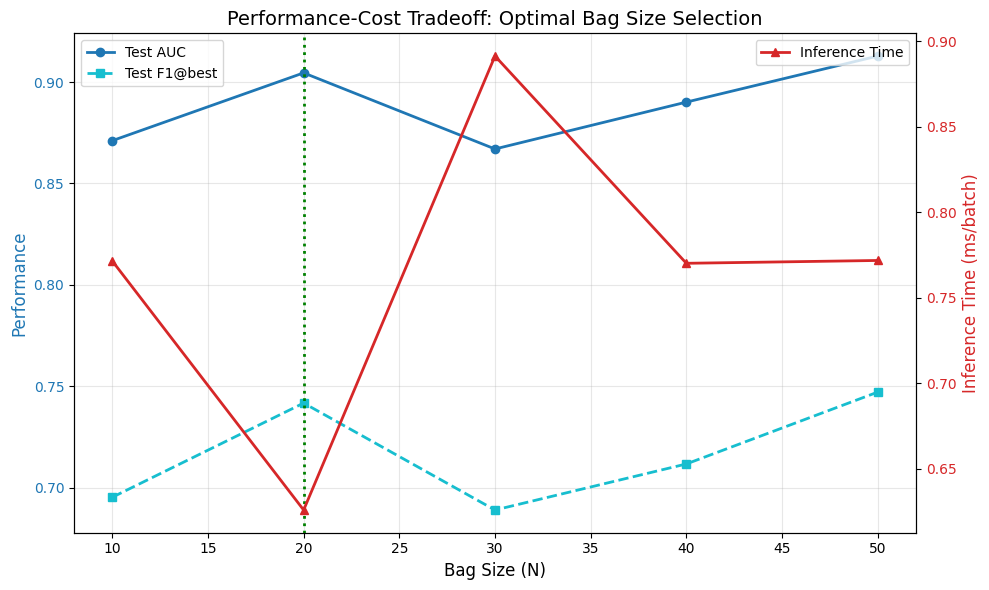

In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

print("=== Performance-Cost Tradeoff Analysis ===")

inference_times = []
for bag_size in BAG_SIZE_GRID:
    ratio_tag = format_ratio_tag(bag_size)
    splits, _, instance_dim = prepare_data_for_ratio(ratio_tag)
    test_loader = make_dataloaders({"test": splits["test"]}, batch_size=BATCH_SIZE)["test"]

    model = AttentionMIL(input_dim=instance_dim, hidden_dim=128, dropout_p=0.1).to(device)
    model.eval()

    import time
    times = []
    with torch.no_grad():
        for X, _ in test_loader:
            X = X.to(device)
            start = time.time()
            _ = model(X)
            torch.cuda.synchronize()
            times.append((time.time() - start) * 1000)

    avg_time = np.mean(times)
    inference_times.append(avg_time)
    print(f"Bag size {bag_size}: {avg_time:.2f} ms/batch")

bag_sizes = results_df["bag_size"].values
aucs = results_df["test_auc"].values
f1s = results_df["test_f1@best"].values

auc_deltas = np.diff(aucs)
knee_idx = None
for i, delta in enumerate(auc_deltas):
    if delta < 0.01:
        knee_idx = i
        break

if knee_idx is not None:
    recommended_N = bag_sizes[knee_idx]
    print(f"Recommended Bag Size (Knee): N* = {recommended_N}")
    print(f"  AUC: {aucs[knee_idx]:.4f}, F1: {f1s[knee_idx]:.4f}")
    print(f"  Inference: {inference_times[knee_idx]:.2f} ms/batch")
else:
    recommended_N = bag_sizes[np.argmax(aucs)]
    print(f"Recommended Bag Size (Max AUC): N* = {recommended_N}")

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Bag Size (N)", fontsize=12)
ax1.set_ylabel("Performance", color="tab:blue", fontsize=12)
ax1.plot(bag_sizes, aucs, "o-", color="tab:blue", label="Test AUC", linewidth=2)
ax1.plot(bag_sizes, f1s, "s--", color="tab:cyan", label="Test F1@best", linewidth=2)
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="upper left")
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel("Inference Time (ms/batch)", color="tab:red", fontsize=12)
ax2.plot(bag_sizes, inference_times, "^-", color="tab:red", label="Inference Time", linewidth=2)
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.legend(loc="upper right")

if knee_idx is not None:
    ax1.axvline(x=recommended_N, color="green", linestyle=":", linewidth=2, label=f"N*={recommended_N}")

plt.title("Performance-Cost Tradeoff: Optimal Bag Size Selection", fontsize=14)
plt.tight_layout()
plt.show()

=== Operational Stability Analysis ===
[30p_single10] Instances per bag: 10, feature dim: 256


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10 – 
  Train Loss: 0.9408, Acc: 0.5175
  Val   Loss: 0.9228, Acc: 0.7742, AUC: 0.8069, F1: 0.5368
  ✅ New best AUC: 0.8069

Epoch 2/10 – 
  Train Loss: 0.8372, Acc: 0.7156
  Val   Loss: 0.8507, Acc: 0.7925, AUC: 0.8146, F1: 0.5546
  ✅ New best AUC: 0.8146

Epoch 3/10 – 
  Train Loss: 0.7214, Acc: 0.7967
  Val   Loss: 0.7887, Acc: 0.8075, AUC: 0.8480, F1: 0.5897
  ✅ New best AUC: 0.8480

Epoch 4/10 – 
  Train Loss: 0.6533, Acc: 0.7994
  Val   Loss: 0.8843, Acc: 0.7842, AUC: 0.8303, F1: 0.4830
  No improvement. Patience: 1/3

Epoch 5/10 – 
  Train Loss: 0.5984, Acc: 0.8294
  Val   Loss: 0.8066, Acc: 0.8075, AUC: 0.8347, F1: 0.6024
  No improvement. Patience: 2/3

Epoch 6/10 – 
  Train Loss: 0.5595, Acc: 0.8450
  Val   Loss: 0.8930, Acc: 0.7917, AUC: 0.8477, F1: 0.5098
  No improvement. Patience: 3/3
  🛑 Early stopping triggered.
Bag size 10: Threshold=0.450, ECE=0.1303, Brier=0.1508
[30p_single20] Instances per bag: 20, feature dim: 256

Epoch 1/10 – 


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9570, Acc: 0.4692
  Val   Loss: 0.9353, Acc: 0.6492, AUC: 0.8138, F1: 0.5901
  ✅ New best AUC: 0.8138

Epoch 2/10 – 
  Train Loss: 0.8715, Acc: 0.6706
  Val   Loss: 0.8758, Acc: 0.7900, AUC: 0.8156, F1: 0.5097
  ✅ New best AUC: 0.8156

Epoch 3/10 – 
  Train Loss: 0.7633, Acc: 0.7622
  Val   Loss: 0.8437, Acc: 0.7867, AUC: 0.8493, F1: 0.4733
  ✅ New best AUC: 0.8493

Epoch 4/10 – 
  Train Loss: 0.6808, Acc: 0.8100
  Val   Loss: 0.8265, Acc: 0.8017, AUC: 0.8566, F1: 0.5352
  ✅ New best AUC: 0.8566

Epoch 5/10 – 
  Train Loss: 0.6237, Acc: 0.8100
  Val   Loss: 0.8927, Acc: 0.7883, AUC: 0.8639, F1: 0.4752
  ✅ New best AUC: 0.8639

Epoch 6/10 – 
  Train Loss: 0.5960, Acc: 0.8283
  Val   Loss: 0.8248, Acc: 0.8067, AUC: 0.8668, F1: 0.5655
  ✅ New best AUC: 0.8668

Epoch 7/10 – 
  Train Loss: 0.5539, Acc: 0.8450
  Val   Loss: 0.8649, Acc: 0.8050, AUC: 0.8811, F1: 0.5412
  ✅ New best AUC: 0.8811

Epoch 8/10 – 
  Train Loss: 0.5296, Acc: 0.8472
  Val   Loss: 0.8853, Acc: 0.8058, 

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9491, Acc: 0.5194
  Val   Loss: 0.9322, Acc: 0.7825, AUC: 0.8313, F1: 0.5584
  ✅ New best AUC: 0.8313

Epoch 2/10 – 
  Train Loss: 0.8506, Acc: 0.6989
  Val   Loss: 0.8723, Acc: 0.7642, AUC: 0.8662, F1: 0.3753
  ✅ New best AUC: 0.8662

Epoch 3/10 – 
  Train Loss: 0.7343, Acc: 0.7919
  Val   Loss: 0.8893, Acc: 0.7442, AUC: 0.8613, F1: 0.2742
  No improvement. Patience: 1/3

Epoch 4/10 – 
  Train Loss: 0.6628, Acc: 0.8214
  Val   Loss: 0.8708, Acc: 0.7692, AUC: 0.8796, F1: 0.3912
  ✅ New best AUC: 0.8796

Epoch 5/10 – 
  Train Loss: 0.6122, Acc: 0.8258
  Val   Loss: 0.8555, Acc: 0.7850, AUC: 0.8751, F1: 0.4691
  No improvement. Patience: 1/3

Epoch 6/10 – 
  Train Loss: 0.5645, Acc: 0.8483
  Val   Loss: 0.8772, Acc: 0.7892, AUC: 0.8659, F1: 0.4909
  No improvement. Patience: 2/3

Epoch 7/10 – 
  Train Loss: 0.5390, Acc: 0.8617
  Val   Loss: 0.9615, Acc: 0.7708, AUC: 0.8710, F1: 0.4111
  No improvement. Patience: 3/3
  🛑 Early stopping triggered.
Bag size 30: Threshold=0.2

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9390, Acc: 0.5500
  Val   Loss: 0.9026, Acc: 0.6250, AUC: 0.8810, F1: 0.6053
  ✅ New best AUC: 0.8810

Epoch 2/10 – 
  Train Loss: 0.8298, Acc: 0.7044
  Val   Loss: 0.8160, Acc: 0.8025, AUC: 0.8512, F1: 0.6208
  No improvement. Patience: 1/3

Epoch 3/10 – 
  Train Loss: 0.7331, Acc: 0.7869
  Val   Loss: 0.7910, Acc: 0.8000, AUC: 0.8806, F1: 0.5312
  No improvement. Patience: 2/3

Epoch 4/10 – 
  Train Loss: 0.6700, Acc: 0.8175
  Val   Loss: 0.7881, Acc: 0.8050, AUC: 0.8781, F1: 0.5551
  No improvement. Patience: 3/3
  🛑 Early stopping triggered.
Bag size 40: Threshold=0.550, ECE=0.3148, Brier=0.2363
[30p_single50] Instances per bag: 50, feature dim: 256

Epoch 1/10 – 


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9453, Acc: 0.4906
  Val   Loss: 0.9130, Acc: 0.7867, AUC: 0.8586, F1: 0.6916
  ✅ New best AUC: 0.8586

Epoch 2/10 – 
  Train Loss: 0.8455, Acc: 0.7014
  Val   Loss: 0.8709, Acc: 0.7592, AUC: 0.8535, F1: 0.3704
  No improvement. Patience: 1/3

Epoch 3/10 – 
  Train Loss: 0.7400, Acc: 0.7875
  Val   Loss: 0.8374, Acc: 0.7792, AUC: 0.8680, F1: 0.4513
  ✅ New best AUC: 0.8680

Epoch 4/10 – 
  Train Loss: 0.6628, Acc: 0.8131
  Val   Loss: 0.7994, Acc: 0.8008, AUC: 0.8733, F1: 0.5413
  ✅ New best AUC: 0.8733

Epoch 5/10 – 
  Train Loss: 0.6062, Acc: 0.8294
  Val   Loss: 0.8576, Acc: 0.7858, AUC: 0.8877, F1: 0.4766
  ✅ New best AUC: 0.8877

Epoch 6/10 – 
  Train Loss: 0.5681, Acc: 0.8439
  Val   Loss: 0.8935, Acc: 0.7958, AUC: 0.8789, F1: 0.5129
  No improvement. Patience: 1/3

Epoch 7/10 – 
  Train Loss: 0.5413, Acc: 0.8494
  Val   Loss: 0.9866, Acc: 0.7817, AUC: 0.8692, F1: 0.4631
  No improvement. Patience: 2/3

Epoch 8/10 – 
  Train Loss: 0.5083, Acc: 0.8692
  Val   Loss: 

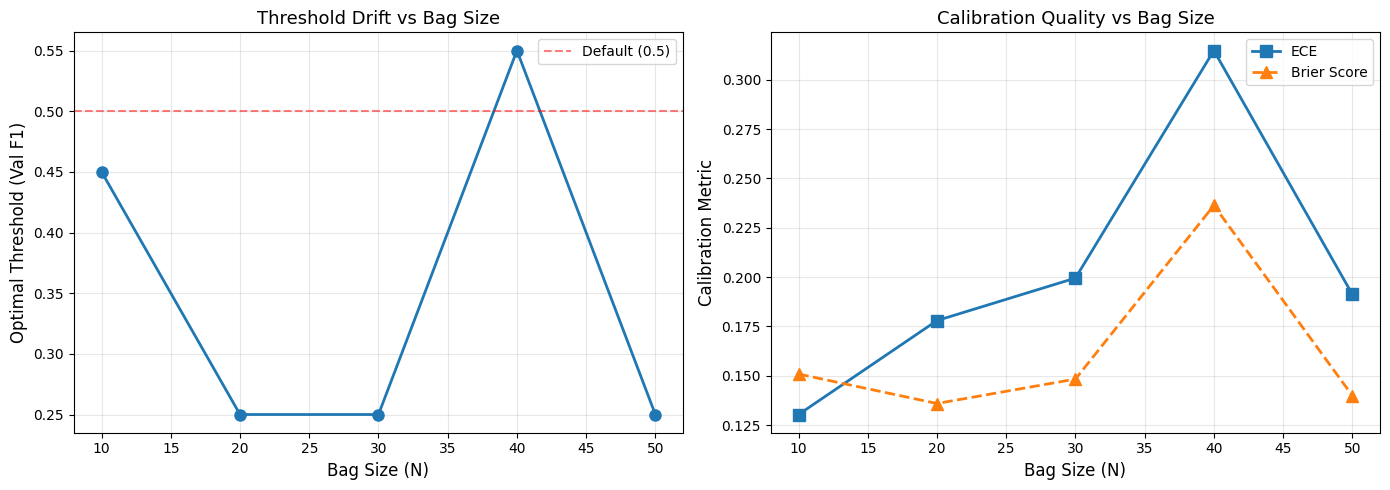

Stability Summary:
  Threshold std: 0.1265
  Avg ECE: 0.2028
  Avg Brier: 0.1622


In [12]:
from sklearn.calibration import calibration_curve

print("=== Operational Stability Analysis ===")

thresholds_collected = []
ece_scores = []
brier_scores = []

for bag_size in BAG_SIZE_GRID:
    ratio_tag = format_ratio_tag(bag_size)
    splits, _, instance_dim = prepare_data_for_ratio(ratio_tag)
    loaders = make_dataloaders(splits, batch_size=BATCH_SIZE)

    model = AttentionMIL(input_dim=instance_dim, hidden_dim=128, dropout_p=0.1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=1, verbose=False)
    pos_weight = torch.tensor([compute_pos_weight(splits["train"]["labels"])], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    model, _, _ = train_model(model, loaders["train"], loaders["val"], optimizer, scheduler, criterion,
                               max_epochs=MAX_EPOCHS, patience=PATIENCE, name="")

    val_metrics = evaluate(model, loaders["val"], criterion)
    val_probs = val_metrics[4]
    val_labels = val_metrics[5]
    best_thr, _ = find_best_threshold(val_probs, val_labels)
    thresholds_collected.append(best_thr)

    n_bins = 10
    prob_true, prob_pred = calibration_curve(val_labels, val_probs, n_bins=n_bins, strategy="uniform")
    ece = np.mean(np.abs(prob_true - prob_pred))
    ece_scores.append(ece)

    brier = np.mean((val_probs - val_labels) ** 2)
    brier_scores.append(brier)

    print(f"Bag size {bag_size}: Threshold={best_thr:.3f}, ECE={ece:.4f}, Brier={brier:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(bag_sizes, thresholds_collected, "o-", linewidth=2, markersize=8)
ax1.set_xlabel("Bag Size (N)", fontsize=12)
ax1.set_ylabel("Optimal Threshold (Val F1)", fontsize=12)
ax1.set_title("Threshold Drift vs Bag Size", fontsize=13)
ax1.grid(alpha=0.3)
ax1.axhline(y=0.5, color="red", linestyle="--", alpha=0.5, label="Default (0.5)")
ax1.legend()

ax2.plot(bag_sizes, ece_scores, "s-", label="ECE", linewidth=2, markersize=8)
ax2.plot(bag_sizes, brier_scores, "^--", label="Brier Score", linewidth=2, markersize=8)
ax2.set_xlabel("Bag Size (N)", fontsize=12)
ax2.set_ylabel("Calibration Metric", fontsize=12)
ax2.set_title("Calibration Quality vs Bag Size", fontsize=13)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Stability Summary:")
print(f"  Threshold std: {np.std(thresholds_collected):.4f}")
print(f"  Avg ECE: {np.mean(ece_scores):.4f}")
print(f"  Avg Brier: {np.mean(brier_scores):.4f}")

=== Localization Consistency: Hit@K Analysis ===
[30p_single10] Instances per bag: 10, feature dim: 256


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10 – 
  Train Loss: 0.9534, Acc: 0.5133
  Val   Loss: 0.9314, Acc: 0.6000, AUC: 0.8201, F1: 0.5660
  ✅ New best AUC: 0.8201

Epoch 2/10 – 
  Train Loss: 0.8581, Acc: 0.6661
  Val   Loss: 0.8518, Acc: 0.8050, AUC: 0.8257, F1: 0.6344
  ✅ New best AUC: 0.8257

Epoch 3/10 – 
  Train Loss: 0.7571, Acc: 0.7728
  Val   Loss: 0.8427, Acc: 0.7858, AUC: 0.8268, F1: 0.4971
  ✅ New best AUC: 0.8268

Epoch 4/10 – 
  Train Loss: 0.6638, Acc: 0.8056
  Val   Loss: 0.8177, Acc: 0.8042, AUC: 0.8410, F1: 0.5656
  ✅ New best AUC: 0.8410

Epoch 5/10 – 
  Train Loss: 0.6300, Acc: 0.8164
  Val   Loss: 0.8295, Acc: 0.8058, AUC: 0.8433, F1: 0.5677
  ✅ New best AUC: 0.8433

Epoch 6/10 – 
  Train Loss: 0.5787, Acc: 0.8314
  Val   Loss: 0.9542, Acc: 0.7842, AUC: 0.8455, F1: 0.4615
  ✅ New best AUC: 0.8455

Epoch 7/10 – 
  Train Loss: 0.5553, Acc: 0.8483
  Val   Loss: 0.9437, Acc: 0.7933, AUC: 0.8477, F1: 0.5079
  ✅ New best AUC: 0.8477

Epoch 8/10 – 
  Train Loss: 0.5285, Acc: 0.8472
  Val   Loss: 0.8289

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9542, Acc: 0.4575
  Val   Loss: 0.9305, Acc: 0.6383, AUC: 0.8040, F1: 0.5882
  ✅ New best AUC: 0.8040

Epoch 2/10 – 
  Train Loss: 0.8606, Acc: 0.6775
  Val   Loss: 0.8654, Acc: 0.7800, AUC: 0.8162, F1: 0.5302
  ✅ New best AUC: 0.8162

Epoch 3/10 – 
  Train Loss: 0.7495, Acc: 0.7869
  Val   Loss: 0.8051, Acc: 0.8008, AUC: 0.8446, F1: 0.5785
  ✅ New best AUC: 0.8446

Epoch 4/10 – 
  Train Loss: 0.6738, Acc: 0.8072
  Val   Loss: 0.8350, Acc: 0.7925, AUC: 0.8548, F1: 0.5030
  ✅ New best AUC: 0.8548

Epoch 5/10 – 
  Train Loss: 0.6206, Acc: 0.8308
  Val   Loss: 0.7643, Acc: 0.8200, AUC: 0.8758, F1: 0.6058
  ✅ New best AUC: 0.8758

Epoch 6/10 – 
  Train Loss: 0.5852, Acc: 0.8225
  Val   Loss: 0.8122, Acc: 0.8042, AUC: 0.8715, F1: 0.5541
  No improvement. Patience: 1/3

Epoch 7/10 – 
  Train Loss: 0.5549, Acc: 0.8431
  Val   Loss: 0.8536, Acc: 0.8000, AUC: 0.8795, F1: 0.5312
  ✅ New best AUC: 0.8795

Epoch 8/10 – 
  Train Loss: 0.5158, Acc: 0.8631
  Val   Loss: 0.8067, Acc: 0

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9484, Acc: 0.5408
  Val   Loss: 0.9218, Acc: 0.6300, AUC: 0.8016, F1: 0.5787
  ✅ New best AUC: 0.8016

Epoch 2/10 – 
  Train Loss: 0.8431, Acc: 0.7028
  Val   Loss: 0.8488, Acc: 0.7975, AUC: 0.8413, F1: 0.5169
  ✅ New best AUC: 0.8413

Epoch 3/10 – 
  Train Loss: 0.7191, Acc: 0.7922
  Val   Loss: 0.8871, Acc: 0.7608, AUC: 0.8681, F1: 0.3462
  ✅ New best AUC: 0.8681

Epoch 4/10 – 
  Train Loss: 0.6379, Acc: 0.8325
  Val   Loss: 0.8099, Acc: 0.7992, AUC: 0.8800, F1: 0.5209
  ✅ New best AUC: 0.8800

Epoch 5/10 – 
  Train Loss: 0.5825, Acc: 0.8450
  Val   Loss: 0.8005, Acc: 0.8058, AUC: 0.8845, F1: 0.5511
  ✅ New best AUC: 0.8845

Epoch 6/10 – 
  Train Loss: 0.5372, Acc: 0.8536
  Val   Loss: 0.9239, Acc: 0.7825, AUC: 0.8883, F1: 0.4551
  ✅ New best AUC: 0.8883

Epoch 7/10 – 
  Train Loss: 0.5219, Acc: 0.8522
  Val   Loss: 0.8299, Acc: 0.8133, AUC: 0.8834, F1: 0.5821
  No improvement. Patience: 1/3

Epoch 8/10 – 
  Train Loss: 0.5003, Acc: 0.8664
  Val   Loss: 0.8768, Acc: 0

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9403, Acc: 0.5594
  Val   Loss: 0.8985, Acc: 0.6217, AUC: 0.8981, F1: 0.6038
  ✅ New best AUC: 0.8981

Epoch 2/10 – 
  Train Loss: 0.8260, Acc: 0.7272
  Val   Loss: 0.7955, Acc: 0.8350, AUC: 0.8808, F1: 0.6743
  No improvement. Patience: 1/3

Epoch 3/10 – 
  Train Loss: 0.7179, Acc: 0.7978
  Val   Loss: 0.7896, Acc: 0.8075, AUC: 0.8801, F1: 0.5549
  No improvement. Patience: 2/3

Epoch 4/10 – 
  Train Loss: 0.6588, Acc: 0.8236
  Val   Loss: 0.8156, Acc: 0.7975, AUC: 0.8838, F1: 0.5091
  No improvement. Patience: 3/3
  🛑 Early stopping triggered.
Bag size 40, Hit@1: 0.414
Bag size 40, Hit@3: 0.561
Bag size 40, Hit@5: 0.614
[30p_single50] Instances per bag: 50, feature dim: 256

Epoch 1/10 – 


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Train Loss: 0.9367, Acc: 0.5528
  Val   Loss: 0.8977, Acc: 0.8308, AUC: 0.8548, F1: 0.6793
  ✅ New best AUC: 0.8548

Epoch 2/10 – 
  Train Loss: 0.8220, Acc: 0.7436
  Val   Loss: 0.8417, Acc: 0.7883, AUC: 0.8549, F1: 0.4858
  ✅ New best AUC: 0.8549

Epoch 3/10 – 
  Train Loss: 0.7083, Acc: 0.7953
  Val   Loss: 0.8124, Acc: 0.8058, AUC: 0.8532, F1: 0.5511
  No improvement. Patience: 1/3

Epoch 4/10 – 
  Train Loss: 0.6393, Acc: 0.8281
  Val   Loss: 0.9498, Acc: 0.7650, AUC: 0.8614, F1: 0.3948
  ✅ New best AUC: 0.8614

Epoch 5/10 – 
  Train Loss: 0.5865, Acc: 0.8408
  Val   Loss: 0.8884, Acc: 0.7983, AUC: 0.8714, F1: 0.5236
  ✅ New best AUC: 0.8714

Epoch 6/10 – 
  Train Loss: 0.5484, Acc: 0.8492
  Val   Loss: 0.8733, Acc: 0.8033, AUC: 0.8889, F1: 0.5426
  ✅ New best AUC: 0.8889

Epoch 7/10 – 
  Train Loss: 0.5168, Acc: 0.8653
  Val   Loss: 1.0379, Acc: 0.7750, AUC: 0.8843, F1: 0.4351
  No improvement. Patience: 1/3

Epoch 8/10 – 
  Train Loss: 0.4938, Acc: 0.8639
  Val   Loss: 0.9769,

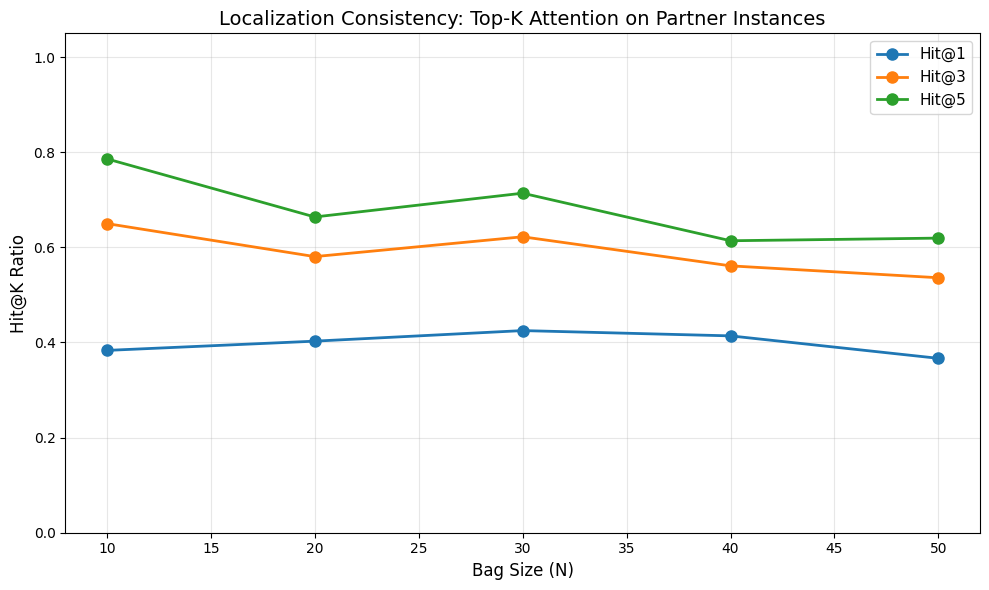

Localization Summary:
  Hit@1: mean=0.398, std=0.021
  Hit@3: mean=0.590, std=0.041
  Hit@5: mean=0.679, std=0.064


In [13]:
print("=== Localization Consistency: Hit@K Analysis ===")

hit_at_k_results = {k: [] for k in [1, 3, 5]}

for bag_size in BAG_SIZE_GRID:
    ratio_tag = format_ratio_tag(bag_size)
    splits, _, instance_dim = prepare_data_for_ratio(ratio_tag)

    test_meta = splits["test"]["meta"]
    test_labels = splits["test"]["labels"]
    test_features = splits["test"]["features"]

    pos_indices = [i for i, y in enumerate(test_labels) if y == 1]

    if not pos_indices:
        for k in hit_at_k_results:
            hit_at_k_results[k].append(0.0)
        continue

    loaders = make_dataloaders(splits, batch_size=BATCH_SIZE)
    model = AttentionMIL(input_dim=instance_dim, hidden_dim=128, dropout_p=0.1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=1, verbose=False)
    pos_weight = torch.tensor([compute_pos_weight(splits["train"]["labels"])], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    model, _, _ = train_model(model, loaders["train"], loaders["val"], optimizer, scheduler, criterion,
                               max_epochs=MAX_EPOCHS, patience=PATIENCE, name="")
    model.eval()

    hit_counts = {k: 0 for k in hit_at_k_results}

    with torch.no_grad():
        for idx in pos_indices:
            X = torch.tensor(test_features[idx], dtype=torch.float32).unsqueeze(0).to(device)
            _, weights = model(X)
            weights_np = weights.squeeze(0).cpu().numpy()

            top_k_indices = np.argsort(weights_np)[::-1]

            meta = test_meta[idx]
            partner_id = meta.get("partner_writer_id")
            instances = meta.get("instances", [])

            partner_positions = []
            for i, inst in enumerate(instances):
                src = inst.get("source_writer")
                if src == partner_id:
                    partner_positions.append(i)

            if not partner_positions:
                continue

            for k in hit_at_k_results:
                top_k = set(top_k_indices[:k])
                if any(p in top_k for p in partner_positions):
                    hit_counts[k] += 1

    n_pos = len(pos_indices)
    for k in hit_at_k_results:
        hit_ratio = hit_counts[k] / n_pos if n_pos > 0 else 0.0
        hit_at_k_results[k].append(hit_ratio)
        print(f"Bag size {bag_size}, Hit@{k}: {hit_ratio:.3f}")

fig, ax = plt.subplots(figsize=(10, 6))

for k, values in hit_at_k_results.items():
    ax.plot(bag_sizes, values, marker="o", linewidth=2, markersize=8, label=f"Hit@{k}")

ax.set_xlabel("Bag Size (N)", fontsize=12)
ax.set_ylabel("Hit@K Ratio", fontsize=12)
ax.set_title("Localization Consistency: Top-K Attention on Partner Instances", fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("Localization Summary:")
for k, values in hit_at_k_results.items():
    avg_hit = np.mean(values)
    std_hit = np.std(values)
    print(f"  Hit@{k}: mean={avg_hit:.3f}, std={std_hit:.3f}")